In [3]:
import sys

import ase.build
import ase.data
import ase.visualize
import e3nn_jax as e3nn
import jax
import jax.numpy as jnp
import jraph
import numpy as np
from tqdm import tqdm

sys.path.append("..")


from symphony.data.input_pipeline import ase_atoms_to_jraph_graph
from symphony.data.qm9 import load_qm9

In [4]:
# Bond lengths from:
# http://www.wiredchemist.com/chemistry/data/bond_energies_lengths.html
# And:
# http://chemistry-reference.com/tables/Bond%20Lengths%20and%20Enthalpies.pdf
dict_bonds1 = {
    "H": {
        "H": 74,
        "C": 109,
        "N": 101,
        "O": 96,
        "F": 92,
        "B": 119,
        "Si": 148,
        "P": 144,
        "As": 152,
        "S": 134,
        "Cl": 127,
        "Br": 141,
        "I": 161,
    },
    "C": {
        "H": 109,
        "C": 154,
        "N": 147,
        "O": 143,
        "F": 135,
        "Si": 185,
        "P": 184,
        "S": 182,
        "Cl": 177,
        "Br": 194,
        "I": 214,
    },
    "N": {
        "H": 101,
        "C": 147,
        "N": 145,
        "O": 140,
        "F": 136,
        "Cl": 175,
        "Br": 214,
        "S": 168,
        "I": 222,
        "P": 177,
    },
    "O": {
        "H": 96,
        "C": 143,
        "N": 140,
        "O": 148,
        "F": 142,
        "Br": 172,
        "S": 151,
        "P": 163,
        "Si": 163,
        "Cl": 164,
        "I": 194,
    },
    "F": {
        "H": 92,
        "C": 135,
        "N": 136,
        "O": 142,
        "F": 142,
        "S": 158,
        "Si": 160,
        "Cl": 166,
        "Br": 178,
        "P": 156,
        "I": 187,
    },
    "B": {"H": 119, "Cl": 175},
    "Si": {
        "Si": 233,
        "H": 148,
        "C": 185,
        "O": 163,
        "S": 200,
        "F": 160,
        "Cl": 202,
        "Br": 215,
        "I": 243,
    },
    "Cl": {
        "Cl": 199,
        "H": 127,
        "C": 177,
        "N": 175,
        "O": 164,
        "P": 203,
        "S": 207,
        "B": 175,
        "Si": 202,
        "F": 166,
        "Br": 214,
    },
    "S": {
        "H": 134,
        "C": 182,
        "N": 168,
        "O": 151,
        "S": 204,
        "F": 158,
        "Cl": 207,
        "Br": 225,
        "Si": 200,
        "P": 210,
        "I": 234,
    },
    "Br": {
        "Br": 228,
        "H": 141,
        "C": 194,
        "O": 172,
        "N": 214,
        "Si": 215,
        "S": 225,
        "F": 178,
        "Cl": 214,
        "P": 222,
    },
    "P": {
        "P": 221,
        "H": 144,
        "C": 184,
        "O": 163,
        "Cl": 203,
        "S": 210,
        "F": 156,
        "N": 177,
        "Br": 222,
    },
    "I": {
        "H": 161,
        "C": 214,
        "Si": 243,
        "N": 222,
        "O": 194,
        "S": 234,
        "F": 187,
        "I": 266,
    },
    "As": {"H": 152},
}

dict_bonds2 = {
    "C": {"C": 134, "N": 129, "O": 120, "S": 160},
    "N": {"C": 129, "N": 125, "O": 121},
    "O": {"C": 120, "N": 121, "O": 121, "P": 150},
    "P": {"O": 150, "S": 186},
    "S": {"P": 186},
}


dict_bonds3 = {
    "C": {"C": 120, "N": 116, "O": 113},
    "N": {"C": 116, "N": 110},
    "O": {"C": 113},
}


def into_matrix(dict, atomic_numbers):
    out = np.zeros((len(atomic_numbers), len(atomic_numbers)))
    for i, zi in enumerate(atomic_numbers):
        for j, zj in enumerate(atomic_numbers):
            xi = ase.data.chemical_symbols[zi]
            xj = ase.data.chemical_symbols[zj]
            if xi in dict and xj in dict[xi]:
                d = dict[xi][xj] / 100
                out[i, j] = d
                out[j, i] = d

    return jnp.asarray(out)

In [5]:
def allocate(graph, per_edge):
    """Allocate electrons to bonds.

    Args:
        graph: undirected graph
        graph.nodes: electrons needing to be shared
        graph.edges: number of electrons shared via bond
        per_edge: number of electrons to add per edge

    Returns: graph with updated edges and nodes
    """
    e = graph.edges
    n = graph.nodes
    s, r = graph.senders, graph.receivers

    # update valence values per edge/node
    e = e + per_edge
    n = n.at[s].add(-per_edge)
    n = n.at[r].add(-per_edge)

    return graph._replace(edges=e, nodes=n)


def allocation_imposed(graph, edge_min, edge_max):
    """Find electrons that absolutely need to be shared.

    Args:
        graph: undirected graph
        graph.nodes: electrons needing to be shared
        graph.edges: number of electrons shared via bond
        edge_min: minimum number of electrons at each edge
        edge_max: maximum number of electrons at each edge

    Returns: number of electrons to add per edge
    """
    num_nodes = graph.nodes.shape[0]
    e = graph.edges
    n = graph.nodes
    s, r = graph.senders, graph.receivers
    min, max = edge_min, edge_max

    ## Situation 1: Share electrons between nodes that have electrons to share
    # a: how many neighbors have electrons to share
    a = jnp.zeros(num_nodes, dtype=jnp.int32)
    a = a.at[s].add((e < max) & (n[r] > 0))
    a = a.at[r].add((e < max) & (n[s] > 0))

    # a: only one neighbor has electrons to share AND I have electrons to share
    a = (a == 1) & (n > 0)

    # edge_alloc1: when one of the two sides NEED to share
    edge_alloc1 = jnp.where(a[s] | a[r], jnp.minimum(n[s], n[r]), 0)

    ## Situation 2: If edge needs more electrons
    edge_alloc2 = jnp.maximum(0, min - e)

    edge_alloc = jnp.maximum(edge_alloc1, edge_alloc2)
    ## Situation 3: If edge_alloc has no electrons being distributed, but some node has electrons to give,
    # choose a conformation in which to distribute electrons.
    # Not Implemented!!

    max_alloc = jnp.maximum(0, max - e)
    edge_alloc = jnp.clip(edge_alloc, 0, max_alloc)

    return edge_alloc


def allocate_while_you_have_to(graph, edge_min, edge_max):
    """Allocate electrons to bonds until we are stuck."""

    def cond(graph):
        a = allocation_imposed(graph, edge_min, edge_max)
        return jnp.any(a > 0)

    def body(graph):
        a = allocation_imposed(graph, edge_min, edge_max)
        return allocate(graph, a)

    return jax.lax.while_loop(cond, body, graph)


def _check_valence(graph, edge_min=None, edge_max=None):
    """Checks if the graph satisfies the valence rules.

    Args:
        graph: undirected graph
        graph.nodes: electrons needing to be shared
        edge_min: minimum number of electrons at each edge
        edge_max: maximum number of electrons at each edge

    Returns: A code per graph
        0 = valence OK
        1 = Algorithm not finished
        2 = Impossible to satisfy valence
    """
    if edge_min is None:
        edge_min = jnp.ones(len(graph.senders), dtype=jnp.int32)
    if edge_max is None:
        edge_max = jnp.ones(len(graph.senders), dtype=jnp.int32) * 3

    graph = graph._replace(edges=jnp.zeros_like(graph.senders))

    graph = allocate_while_you_have_to(graph, edge_min, edge_max)

    # def f(e, emin, emax, n, s, r):
    #     m = emax > 0
    #     print("senders:   ", s[m])
    #     print("receivers: ", r[m])
    #     print("edge: min, val, max")
    #     print(
    #         np.stack(
    #             [emin[m], e[m], emax[m]],
    #         )
    #     )
    #     print("node: val")
    #     print(n)

    # jax.debug.callback(
    #     f, graph.edges, edge_min, edge_max, graph.nodes, graph.senders, graph.receivers
    # )

    edge_mistakes = (graph.edges < edge_min) | (edge_max < graph.edges)
    node_mistakes = graph.nodes < 0
    node_incomplete = graph.nodes > 0

    m = e3nn.scatter_sum(node_mistakes, nel=graph.n_node)
    m += e3nn.scatter_sum(edge_mistakes, nel=graph.n_edge)
    i = e3nn.scatter_sum(node_incomplete, nel=graph.n_node)

    return jnp.where(m == 0, jnp.where(i == 0, 0, 1), 2)


@jax.jit
def check_valence(graph, bonds1, bonds2, bonds3, valence):
    """
    Args:
        graph: bidirectional graph
        graph.nodes.positions: (n_nodes, 3)
        graph.nodes.species: (n_nodes,)
        bonds1: (n_species, n_species)
        bonds2: (n_species, n_species)
        bonds3: (n_species, n_species)
        valence: (n_species,)

    Returns: A code per graph
        0 = valence OK
        1 = Algorithm not finished
        2 = Impossible to satisfy valence
    """

    d = jnp.linalg.norm(
        graph.nodes.positions[graph.senders] - graph.nodes.positions[graph.receivers],
        axis=-1,
    )
    si = graph.nodes.species[graph.senders]
    sj = graph.nodes.species[graph.receivers]

    # min-max based on distance and typical bond lengths
    b1 = bonds1[si, sj] + 0.01
    b2 = bonds2[si, sj] - 0.01
    b3 = bonds3[si, sj]
    # With those settings on QM9: 14% pass, 86% not finished, 1 impossible

    edge_min = jnp.where(d < b1, jnp.where(d < b2, jnp.where(d < b3, 3, 2), 1), 0)
    edge_max = jnp.where(d < b1, jnp.where(d < b2, 3, 2), 1)

    # bidirectional into unidirectional:
    edge_min = jnp.where(graph.senders < graph.receivers, edge_min, 0)
    edge_max = jnp.where(graph.senders < graph.receivers, edge_max, 0)

    return _check_valence(
        graph._replace(nodes=valence[graph.nodes.species]), edge_min, edge_max
    )

In [6]:
mol = ase.build.molecule("CH3ONO")
nn_cutoff = 5.0

atomic_numbers = jnp.array([1, 6, 7, 8, 9])
valence = jnp.array([1, 4, 3, 2, 1])

bonds1 = into_matrix(dict_bonds1, atomic_numbers)
bonds2 = into_matrix(dict_bonds2, atomic_numbers)
bonds3 = into_matrix(dict_bonds3, atomic_numbers)

graph = ase_atoms_to_jraph_graph(mol, atomic_numbers, nn_cutoff)

check_valence(graph, bonds1, bonds2, bonds3, valence)

Array([1], dtype=int32, weak_type=True)

In [7]:
# ase.visualize.view(mol, viewer="x3d")

In [8]:
dataset = load_qm9("./qm9_data/")
graphs = [
    ase_atoms_to_jraph_graph(mol, atomic_numbers, nn_cutoff) for mol in tqdm(dataset)
]

44827648it [04:19, 173075.63it/s]                               
100%|██████████| 133885/133885 [00:05<00:00, 23538.75it/s]


In [9]:
max([g.nodes.positions.shape[0] for g in graphs])

29

In [10]:
valence_check = []

for graph in tqdm(graphs):
    graph = jraph.pad_with_graphs(graph, 32, 740)
    out = check_valence(graph, bonds1, bonds2, bonds3, valence)
    valence_check.append(out[0])

100%|██████████| 133885/133885 [00:30<00:00, 4353.88it/s]


In [11]:
np.bincount(valence_check) / len(valence_check)

array([1.44400045e-01, 8.55592486e-01, 7.46909661e-06])

In [12]:
np.bincount(valence_check)

array([ 19333, 114551,      1])

In [13]:
indices = np.where(np.array(valence_check) == 2)[0]

In [14]:
i = indices[0]
mol = dataset[i]
print(i)
graph = ase_atoms_to_jraph_graph(mol, atomic_numbers, nn_cutoff)
print(valence[graph.nodes.species])
ase.visualize.view(mol, viewer="x3d")

130666
[4 4 1 4 3 3 4 2 4 3]


In [15]:
jnp.set_printoptions(precision=2, suppress=True)

In [16]:
check_valence(graph, bonds1, bonds2, bonds3, valence)

Array([2], dtype=int32, weak_type=True)

In [17]:
d = jnp.linalg.norm(
    graph.nodes.positions[graph.senders] - graph.nodes.positions[graph.receivers],
    axis=-1,
)
d

Array([1.37, 2.16, 2.38, 2.43, 2.51, 1.5 , 2.42, 1.42, 2.58, 1.37, 1.08,
       1.45, 2.17, 2.88, 2.55, 3.65, 2.42, 3.47, 2.16, 1.08, 2.22, 3.17,
       3.96, 3.54, 4.57, 2.7 , 3.51, 2.38, 1.45, 2.22, 1.2 , 2.35, 2.84,
       4.03, 3.7 , 4.82, 2.43, 2.17, 3.17, 1.2 , 1.22, 2.19, 3.29, 3.85,
       2.51, 2.88, 3.96, 2.35, 1.22, 1.52, 2.35, 3.8 , 4.91, 1.5 , 2.55,
       3.54, 2.84, 2.19, 1.52, 1.19, 2.46, 3.49, 2.42, 3.65, 4.57, 4.03,
       3.29, 2.35, 1.19, 2.85, 3.61, 1.42, 2.42, 2.7 , 3.7 , 3.85, 3.8 ,
       2.46, 2.85, 1.16, 2.58, 3.47, 3.51, 4.82, 4.91, 3.49, 3.61, 1.16],      dtype=float32)

In [18]:
graph.nodes.positions

array([[-0.01,  0.  ,  0.09],
       [ 0.07,  0.  ,  1.46],
       [ 1.  ,  0.  ,  2.  ],
       [-1.22,  0.  ,  2.13],
       [-2.1 ,  0.  ,  1.32],
       [-2.51,  0.  ,  0.17],
       [-1.28,  0.  , -0.71],
       [-1.4 ,  0.  , -1.89],
       [ 1.18,  0.  , -0.69],
       [ 2.17,  0.  , -1.3 ]])

In [19]:
valence[graph.nodes.species]

Array([4, 4, 1, 4, 3, 3, 4, 2, 4, 3], dtype=int32)

In [20]:
valence

Array([1, 4, 3, 2, 1], dtype=int32)

In [21]:
import matplotlib.pyplot as plt

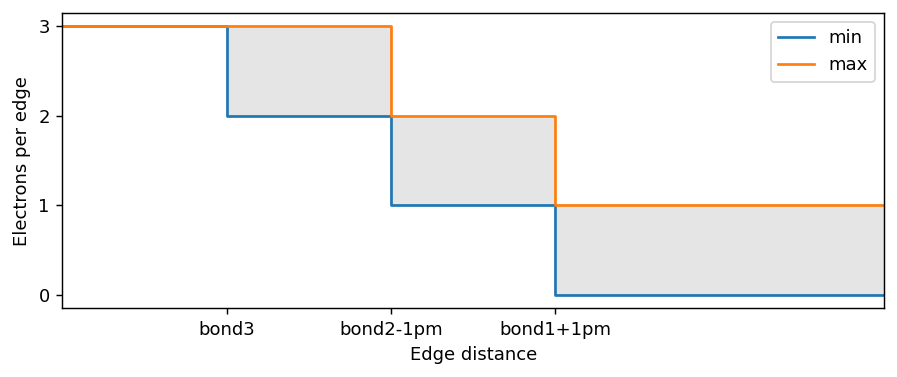

In [22]:
x = [0, 1, 1, 2, 2, 3, 3, 6]
y1 = [3, 3, 2, 2, 1, 1, 0, 0]
y2 = [3, 3, 3, 3, 2, 2, 1, 1]

plt.figure(figsize=(7, 3), dpi=130)
plt.plot(x, y1, "-", label="min")
plt.plot(x, y2, "-", label="max")
plt.fill_between(x, y1, y2, color="gray", alpha=0.2)
plt.legend()
plt.xlim(0, 5)
plt.xticks([1, 2, 3], ["bond3", "bond2-1pm", "bond1+1pm"])
plt.yticks([0, 1, 2, 3])
plt.ylabel("Electrons per edge")
plt.xlabel("Edge distance")
plt.tight_layout()